#Introduction

The PTB-XL ECG dataset is a large dataset of 21801 clinical 12-lead ECGs from 18869 patients of 10 second length. It was collected over seven years and contains extensive metadata on demographics, infarction characteristics, likelihoods for diagnostic ECG statements as well as annotated signal properties. The raw waveform data was annotated by up to two cardiologists, who assigned potentially multiple ECG statements to each record which conform to the SCP-ECG standard. Recommended splits into training and test sets are provided.

In [ ]:
#@title Setup

%%capture
!pip install ipython-autotime
!pip install wfdb
!pip install neurokit2

%load_ext autotime

time: 1.17 ms (started: 2023-03-02 15:38:17 +00:00)


In [ ]:
#@title Imports

import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import neurokit2 as nk
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from wfdb.processing import *
from itertools import product

time: 2.42 s (started: 2023-03-02 15:38:17 +00:00)


#Functions

Below you will find the functions I implemented for the pre-processing, analysis, and plotting of the ECG signals. They are all thoroughly commented and explained, but here is a summary:

**Pre-processing**

The normalize_signals function takes in an array of signals and normalizes them to a desired range.

The denoise_ecg function takes in an array of signals and denoises them using a high-pass butterworth filter followed by powerline filtering.

**Analysis**

The analyze_signals function takes in an array of signals and prints out the heart rate, number of beats, and R-peak indices.

The extract_features function takes in a signal and extracts important ECG features such as R-peaks and the ST interval.

**Plotting**

The plot_signals function takes in an array of signals and plots them in a graph with the given frequency. 

The plot_QRS function takes in an array of signals and the indices of the R-peaks and plots the QRS complexes of the electrocardiogram signal.



***I will delve deeper into my choices and approach as I apply them to the dataset.***

In [ ]:
#@title Functions

def normalize_signals(signals, min = 0, max = 1):
  """
  This function normalizes a signal to a desired range.
  
  Parameters
  ----------
  signals: Array-like with shape (features, channels) or (samples, features, channels)
      The signal(s) to be normalized
  min : int, optional
      The lower bound of the desired range, by default 0
  max : int, optional
      The higher bound of the desired range, by default 1

  Returns : The normalized signal(s).
  """

  normalized_signals = signals.copy()
  
  # Check if the signals are 2-dimensional or 3-dimensional
  if len(signals.shape) == 3:
    # Loop through each sample
    for i in range(signals.shape[0]):
      # Loop through each channel
      for j in range(signals.shape[2]):
        # Normalize the signal
        min_signal = np.min(signals[i,:, j], axis = 0)
        max_signal = np.max(signals[i,:, j], axis = 0)
        std_signal = np.std(signals[i,:, j], axis = 0)
        range_signal = max_signal - min_signal
        normalized_signals[i, :, j] = (signals[i,:, j] - min_signal) * (max - min) / range_signal + min
    return normalized_signals
  
  # If the signals are 2-dimensional
  elif len(signals.shape) == 2:
      # Loop through each sample
      for j in range(signals.shape[1]):
        # Normalize the signal
        min_signal = np.min(signals[:,j], axis = 0)
        max_signal = np.max(signals[:,j], axis = 0)
        std_signal = np.std(signals[:,j], axis = 0)
        range_signal = max_signal - min_signal

        normalized_signals[:, j] = (signals[:,j] - min_signal) * (max - min) / range_signal + min
      return normalized_signals
  
  else:
    raise ValueError('Signal must be 2 or 3 dimensional.')

def denoise_ecg(signals, fs = 100):
  """
  This function denoises ECG signals using a high-pass butterworth filter followed by powerline filtering


  Parameters
  ----------
      signals :  Array-like with shape (features, channels) or (samples, features, channels)
          The signals to denoise   
      fs : int, optional
          The sampling frequency of the signals, by default 100

  Returns : The denoised signal(s).
  """

  
  # Make a copy of the input signals
  result = signals.copy()
  
  # If there are 2 dimensions in the signals
  if len(signals.shape) == 2:
    # Loop through each channel
    for i in range(signals.shape[1]):
      # Clean the signal using a high-pass butterworth filter followed by powerline filtering
      result[:,i] = nk.ecg_clean(signals[:,i], fs, method='neurokit')

  # If there are 3 dimensions in the signals    
  else:
    # Loop through each sample
    for j in range(signals.shape[0]):
      # Loop through each channel
      for i in range(signals.shape[2]):
        # Clean the signal using a high-pass butterworth filter followed by powerline filtering
        result[j,:,i] = nk.ecg_clean(signals[j, :,i], fs, method='neurokit')

  return result

def analyze_signals(signals, fs=100):
    """
    Analyzes the signals passed as argument, prints HR, number of beats, R-peak indices and returns the HR and the R-peak indices.

    Parameters
    ----------
    signals :  Array-like with shape (features, channels)
        The signals to analyze
    fs : int, optional
        The sampling frequency of the signals, by default 100
    
    Returns : Heart rate and R-peak indices.
    """

    # Initialize the values to be returned
    heart_rate = None
    r_peaks = []

    # Iterate through each channel
    for i in range(signals.shape[1]):
        # Clean the signal using a high-pass butterworth filter followed by powerline filtering
        ecg_cleaned = nk.ecg_clean(signals[:,i], sampling_rate=sampling_rate)
        # Processes the signal computing HR, R_peaks and more
        ecg_processed = nk.ecg_process(ecg_cleaned, sampling_rate=sampling_rate)[0]

        # Get the heart rate and the R peaks
        heart_rates = ecg_processed["ECG_Rate"]
        heart_rate = ecg_processed["ECG_Rate"].mean()
        rpeaks = np.array(ecg_processed["ECG_R_Peaks"]).nonzero()[0]
            
        # Print the results
        print("Signal ", i)
        print('Heart rate:', heart_rate, 'BPM')
        print('Number of beats detected: ', len(rpeaks))
        print('R peaks detected at: ', rpeaks, 'ms\n')

    # Return the heart rate and the R peaks
    return {"r_peaks": rpeaks, "heart_rate": heart_rate}  

def extract_features(X_data, Y_data):
  """
  Extracts the features and labels from the signals and metadata. 

  Parameters
  ----------
      X_data : Array-like with shape (samples, features, channels)
          The ecg signals to be processed
      Y_data : Dataframe 
          A dataframe containing the 'age' and 'sex' features and a one-hot encoding of the superclasses in the last columns

  """
  # Create an empty numpy array to hold the extracted features
  X_features_data = np.zeros((X_data.shape[0],20))

  # Loop through each sample in the dataset
  for i in range(X_data.shape[0]):
    
    # Simplistic workaround because neurokit sometimes tries to access non-existent areas of the array.
    # In case of error we therefore just fill the features with the median value of the column.
    # There are better approaches, but for the purposes of this challenge, it should be sufficient.
    try:
      # Clean the ECG data
      ecg_cleaned = nk.ecg_clean(X_data[i,:,0], sampling_rate=sampling_rate)

      # Process the cleaned ECG data
      ecg_processed = nk.ecg_process(ecg_cleaned, sampling_rate=sampling_rate)[0]

      # Get the indices of the Q peaks, P peaks, S peaks, T offsets, T onsets, and P offsets in the processed ECG data
      ecg_q_peaks_indices = ecg_processed["ECG_Q_Peaks"].to_numpy().nonzero()[0]
      ecg_p_peaks_indices = ecg_processed["ECG_P_Peaks"].to_numpy().nonzero()[0]
      ecg_s_peaks_indices = ecg_processed["ECG_S_Peaks"].to_numpy().nonzero()[0]
      ecg_t_peaks_indices = ecg_processed["ECG_T_Offsets"].to_numpy().nonzero()[0]
      ecg_t_onsets_indices = ecg_processed["ECG_T_Onsets"].to_numpy().nonzero()[0]
      ecg_p_offsets_indices = ecg_processed["ECG_P_Offsets"].to_numpy().nonzero()[0]

      # Approximations of important features such as PR interval, ST interval, ST segment, and QRS duration
      # Identifying the S-offset \ J-point and Q-onset would help make these intervals more precise
      # The current approach approximates PR interval from the distance of the peaks rather than of the onsets 
      # The ST interval from the distance of the peaks rather than of the offsets
      # The ST segment uses the the S-peak rather than the S-offset
      # The QRS duration uses the P-offset and T-onset.
      q_p, p_p = sorted(product(ecg_q_peaks_indices , ecg_p_peaks_indices), key=lambda t: abs(t[0]-t[1]))[0]
      s_p, t_p = sorted(product(ecg_s_peaks_indices , ecg_t_peaks_indices), key=lambda t: abs(t[0]-t[1]))[0]
      s_p2, t_on = sorted(product(ecg_s_peaks_indices , ecg_t_onsets_indices), key=lambda t: abs(t[0]-t[1]))[0]
      p_off, t_on = sorted(product(ecg_p_offsets_indices , ecg_t_onsets_indices), key=lambda t: abs(t[0]-t[1]))[0]

      """
      The features are the mean amplitude values of:
      ["ECG_R_Peaks", "ECG_P_Peaks", "ECG_Q_Peaks", "ECG_S_Peaks", "ECG_T_Peaks", "ECG_P_Onsets", 
      "ECG_P_Offsets", "ECG_R_Onsets", "ECG_R_Offsets", "ECG_T_Onsets", "ECG_T_Offsets", "ECG_Phase_Atrial", 
      "ECG_Phase_Completion_Atrial", "ECG_Phase_Ventricular", "ECG_Phase_Completion_Ventricular"]
      
      The heart rate.

      And the shortest duration of the:
      ["PR_Segment", "ST_Interval", "ST_Segment",  "QRS_Duration"]
      """

      X_features_data[i, :] = [np.mean(X_data[i, np.where(ecg_processed["ECG_R_Peaks"].values == 1)[0] - 1]),
                                np.mean(X_data[i, np.where(ecg_processed["ECG_P_Peaks"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_Q_Peaks"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_S_Peaks"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_T_Peaks"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_P_Onsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_P_Offsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_R_Onsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_R_Offsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_T_Onsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_T_Offsets"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_Phase_Atrial"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_Phase_Completion_Atrial"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_Phase_Ventricular"].values == 1)[0] - 1]), 
                                np.mean(X_data[i, np.where(ecg_processed["ECG_Phase_Completion_Ventricular"].values == 1)[0] - 1]),
                                np.mean(ecg_processed["ECG_Rate"]),
                                q_p - p_p,
                                s_p - t_p,
                                s_p2 - t_on,
                                t_on - p_off] 
    except:
      X_features_data[i, :] = [None] * X_features_data.shape[1]

  # Replace NaN values with the median of the feature data
  X_features_data = np.where(np.isnan(X_features_data), np.nanmedian(X_features_data, axis=0), X_features_data)

  # Get the ages and sex from the Y_data
  ages = Y_data[['age']].values
  sex =  Y_data[['sex']].values
  # Concatenate the ages and sex to the X_features_data array
  X_features_data = np.hstack([X_features_data, ages, sex])

  # Get the labels from the Y_data
  y_features_data = Y_data.iloc[:, -5:].astype(int)
  
  return X_features_data, y_features_data


def plot_signals(signals, frequency=100):

  """
  Plot signals in a graph with the given frequency.
  
  Parameters
  ----------
  signals :  Array-like with shape (features) or (features, channels)
      The signals to be plotted
  frequency : int, optional
      The frequency of the given signals, by default 100. This is used to set the x-axis of the plot
  """

  # Set the sample rate to the given frequency
  fs = frequency
  # Create an array of timestamps based on the sample rate
  t = np.arange(signals.shape[0]) / fs
  # Reshape the signals into a 2D array
  signals = np.reshape(signals, (signals.shape[0], -1))

  # Set the duration of the plot boxes
  large_box_duration = 0.2
  small_box_duration = 0.04

  # Set the channel names, used if exactly 12 channels are given.
  channel_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  # Iterate through each signal
  for i in range(signals.shape[1]):     

      # Plot settings
      fig, ax = plt.subplots(figsize=(22, 4))
      ax.spines['right'].set_visible(False)
      ax.spines['top'].set_visible(False)
      ax.spines['bottom'].set_linewidth(2)
      ax.spines['left'].set_linewidth(2)
      ax.xaxis.set_tick_params(width=2, length=8, direction='out', labelsize=12)
      ax.yaxis.set_tick_params(width=2, length=8, direction='out', labelsize=12)
      fig.patch.set_facecolor('white')

      # Set the labels
      ax.set_xlabel('Time (s)')
      ax.set_ylabel('Amplitude (mV)')

      # Set the title of the plot, if the number of channels is 12, assume it's the standard 12-channel format.
      if signals.shape[1] == 12:
        ax.set_title(channel_names[i], fontsize=16)
      else:
        ax.set_title('ECG Waveform', fontsize=16)
      
      # Apply standards for ECG display
      ax.grid(True, which='both', linestyle='dotted')
      ax.plot(t, signals[:, i], color='black')
      ax.set_xlim(0, t[-1])
      ax.set_xticks(np.arange(0, 10, 0.2))
      # Iterate through each large box
      for i in range(int(t[-1] // large_box_duration)+1):
        # Add a vertical line to the plot
        plt.axvline(x=i*large_box_duration, color='pink', linestyle='dotted', linewidth=1)
        # Iterate through each small box
        for j in range(5):
          # Add a vertical line to the plot
          plt.axvline(x=i*large_box_duration + j*small_box_duration, color='pink', linestyle='dotted', linewidth=0.5)  

      ylim = 3
      for k in range( -ylim * 10, ylim * 10):
        plt.axhline(y=k*0.1, color='pink', linestyle='dotted', linewidth=0.5)  

      ax.set_ylim(-ylim, ylim)

      plt.show()
   

def plot_QRS(ecg_signals, r_peaks, sampling_rate = 100):
  """
  Plots the QRS complexes of an electrocardiogram signal. 

  Parameters
  ----------
      ecg_signals :  Array-like with shape (features, channels)
          The signals to plot
      rpeaks :
          The indices of the R-peaks
      sampling_rate : int
          The sampling frequency of the signals, by default 100
  """

  # An array of zeros the same size as ecg_signals
  ecg_centered = np.zeros_like(ecg_signals)
  
  # Set the width of each window to 1/18th of the sampling rate, assumes 0.12s~ QRS complex duration
  width = int(sampling_rate / 18)

  # Loop over each channel
  for i in range(ecg_signals.shape[1]):
      # Loop over each R-peak
      for r in r_peaks:
        # Set the values with a 0.6s~ window of the R-peak to their original value
        ecg_centered[r - width : r + width, i] = ecg_signals[r - width:r + width, i]
  # plot the QRS complex
  plot_signals(ecg_centered)

time: 21.7 ms (started: 2023-03-02 15:38:19 +00:00)


In [ ]:
#@title Settings

path = '/content/physionet.org/content/physionet.org/files/ptb-xl/1.0.2/'
sampling_rate=100
testsample = 37

time: 1.21 ms (started: 2023-03-02 15:38:19 +00:00)


In [ ]:
#@title Load dataset

%%capture
if os.path.exists("/content/drive/MyDrive/physionetdataset.zip") and not os.path.exists("/content/physionet.org.zip"):
  !cp  /content/drive/MyDrive/physionetdataset.zip /content/physionet.org.zip
  !unzip /content/physionet.org.zip -d /content/physionet.org
else:
  !wget -r -N -c -np https://physionet.org/files/ptb-xl/1.0.2/

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')

def load_raw_data(df, sampling_rate, path):
  if sampling_rate == 100:
      data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
  else:
      data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
  data = np.array([signal for signal, meta in data])
  return data

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
 
# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(lambda x: list(set(agg_df.loc[set(x) & set(agg_df.index)].diagnostic_class)))

# Create columns based on diagnostic superclass
columns = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
for col in columns:
    Y[col] = Y['diagnostic_superclass'].apply(lambda x: col in x)

time: 3min 51s (started: 2023-03-02 15:38:19 +00:00)


#Metadata

Let us briefly discuss the metadata that accompanies the PTB-XL database.

**Patient_id**: it is fundamental for fold generation within the dataset, as the same patient should never be both part of the training and testing dataset. Failure to do so causes overfitting and decreases the validity of the metrics.

**Nurse, site, device, and recording_date**: they represent the nurse, the location, the device and the time the ECG signal recording. Ideally, this data should be mostly independent of the results, although inevitably its bias will affect the recordings. In case of large abnormalities in the data distribution, they can be useful to pinpoint the source.

**Report**: It is a brief note written by the medical practitioner, containing information that can be generally found in the rest of the record but not always e.g. "sinus tachycardia t-change, such as in anterolateral myocardial affection ischemic changes that were not present on EKG 910218" (ecg_id 135)  contains information that clearly cannot be found elsewhere on the record. This feature could be used as part of a multimodal approach but might not be worth increasing the complexity of the system and training if important information is already contained in a standardized format in the rest of the record.

**SCP Codes**: The SCP codes column contains the SCP codes associated with the patient's medical report. SCP codes are standardized codes used to identify specific medical conditions and procedures. These codes are used to ensure that the patient's medical report is accurately recorded and can be easily accessed by healthcare providers.

**Heart Axis**: The heart axis column contains the patient's heart axis, which is a measure of the direction of the electrical activity of the heart.

**Infarction Stadium 1\\2**: They are a measure of the severity of the heart attack. This measure is based on the size of the area of the heart muscle that has been damaged by the heart attack.

**validated_by, second_opinion, initial_autogenerated_report, validated_by_human**: These columns were used by the publishers of the dataset to create its folds, ensuring that all the data in the validation and test folds was validated by a second human opinion. All the initial_autogenerated_report rows are False and all the validated_human_rows are True as each sample was validated by at least one human.

**baseline_drift, static_noise, burst_noise**: these three columns contain important information on the quality of the signal but their use requires a certain degree of observation and planning. Here are some of the approaches I envisioned: 

First of all to denoise with an appropriate filter each sample, ensuring that the dataset is generally clean from noise and that the model can learn from the best data possible. This approach however has the drawback of not teaching the model how to behave when it inevitably meets noise in the test samples. Of course, filtering all test samples is an option, but this approach might be destructive towards important features of the signal. 

Another option would be to train a second model for multilabel noise detection and then apply filters according to its predictions, this would reduce the number of non-noisy samples that have to be filtered but increases the complexity of the task by introducing multiple models that need to be trained and work together.

A second approach would be to employ noise samples, allowing the model to learn of their existence and therefore become more robust towards them. Artificial noisy samples could even be generated through dataset augmentation, ensuring that the model is capable of tackling a variety of possible disturbances. This makes the training process more complex and potentially unstable.

While not exactly a third separate approach, denoising with deep learning can make the first approach more viable. Training a model to reconstruct signals by removing noise from them while learning to preserve noiseless signals is possible. With this approach, the filter could be effectively applied to all samples without being too destructive. The model would then be trained and tested only on filtered samples.

**electrodes_problems,  extra_beats,  pacemaker**: these three columns indicate irregularities within the samples in the form of issues with the electrodes, extra beats of the heart outside of its rhythm and the presence of a pacemaker. They are a relatively tiny part of the dataset but common enough that their occurrence cannot be ignored. 

Electrodes problems likely require a model able to recognize them and disable their input. This approach would however necessitate the model to be capable of functioning without one of its inputs, which is not necessarily true of all architectures. On the other hand, the electrodes problem detection model can simply be used to warn the medical practitioner of the issue and demand it be solved before continuing with the automated diagnosis, which is also a viable approach.

Extra beats can be an important source of information on underlying medical issues with the heart. Common heart issues associated with extra beats include arrhythmias, such as atrial fibrillation, ventricular tachycardia, and supraventricular tachycardia. 

The pacemaker manifests as a spike and the change is quite clear and abrupt. The label is very rare in this dataset, but the signal is likely to confuse the model during training if it is not used. 

**R_peaks**: the column contains the indices of the R-peaks present in the signal. Through my observation and validation, I have concluded that this column fails to detect a variety of r_peaks that are visible to my untrained eye and can be detected via signal analysis. It is likely better to discard it and compute one's own R-peaks in case of need.

**Subclasses**: RS-LVH  S12-LVH R56-LVH QRS-LVH LI-LVH  SLI-LVH QRS-CLBB  ST-ELEV-MI  ST-DEPR-MI  Q-ISC Q-ISC-QPeak Q-ISC-V2V3  Q-ISC-RPeak STRAIN  MI-ALL are all conditions that relate to the health of the heart. For this challenge, these subclass labels are discarded, focusing instead on the superclasses.


**Superclasses**:Finally, I preprocessed the dataset to obtain 5 more columns containing a one-hot encoding of the superclasses: Normal, Myocardial Infarction, ST-segment /T-wave Change, Conduction Disturbance, and Hypertrophy.


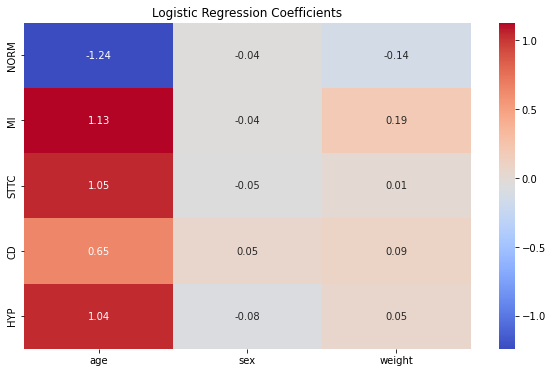


Accuracy for NORM: 0.7289220917822838
Accuracy for MI: 0.8345784418356457
Accuracy for STTC: 0.7908217716115261
Accuracy for CD: 0.8084311632870864
Accuracy for HYP: 0.8959445037353255
time: 631 ms (started: 2023-03-02 15:42:10 +00:00)


In [ ]:
#@title What metadata can tell us


# Step 1: Split the data into training and testing sets
new_df = Y[(Y.iloc[:, -5:] == True).any(axis=1)]
subset_df = new_df[['age', 'sex', 'height', 'weight', 'NORM', 'MI', 'STTC', 'CD', 'HYP']]
subset_df = subset_df.dropna(subset=['weight'])

X_sub = subset_df[['age', 'sex', 'weight']].values
y_sub = subset_df[['NORM', 'MI', 'STTC', 'CD', 'HYP']].values
X_sub[X_sub[:, 0] > 90] = 90
X_train, X_test, y_train, y_test = train_test_split(X_sub, y_sub, test_size=0.2, random_state=42)

# Step 2: Normalize the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train a classifier for each target category
clfs = []
for i in range(5):
    clf = LogisticRegression()
    clf.fit(X_train, y_train[:, i])
    clfs.append(clf)

# Step 4: Evaluate the performance of the classifier
accuracies = []
for i in range(5):
    y_pred = clfs[i].predict(X_test)
    accuracies.append(accuracy_score(y_test[:, i], y_pred))


coef_data = []
for i in range(5):
    coef_row = []
    for j, feature in enumerate(['age', 'sex', 'weight']):
        coef_row.append(clfs[i].coef_[0][j])
    coef_data.append(coef_row)

coef_df = pd.DataFrame(data=coef_data, index=['NORM','MI','STTC','CD','HYP'], columns=['age', 'sex', 'weight'])

# create a heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(coef_df, cmap='coolwarm', annot=True, fmt='.2f', ax=ax)
plt.title('Logistic Regression Coefficients')
plt.show()

print('\nAccuracy for NORM:', accuracies[0])
print('Accuracy for MI:', accuracies[1])
print('Accuracy for STTC:', accuracies[2])
print('Accuracy for CD:', accuracies[3])
print('Accuracy for HYP:', accuracies[4])

**What can metadata tell us?**

In this section, I have trained a simple logistic regression model on three features: Age, Sex and Weight. In order to train the model I had to set aside all the data that did not have the values for the weight class, but we will look into that more later.

Before this experiment I expected to find a strong correlation between these variables and the superclasses, and I was not completely off the mark. Age is clearly the best predictor for all these diseases, a not-so-surprising result. Interestingly, Sex seems to have a rather low impact as a predictor, and similarly, Weight has a lower impact than I expected when compared with Age.

Of course, it needs to be taken into account that sex and weight are correlated, which causes the variables' importance to interact with one another. This means that the impact of Sex might partially be disguised by Weight, and vice versa. Nevertheless, Weight seems to positively predict all kinds of heart diseases as one would expect, so the model cannot be too far off.

Another important factor to notice is the accuracy obtained from these results. Through these three features alone we were able to achieve relatively high accuracy for all these superclasses, meaning that Age and other features can greatly predict health and heart diseases, making them good features to have in our models. Of course, it would be nice to also introduce some more features related to the ECG signal itself, which will be discussed in the latter part of this notebook.

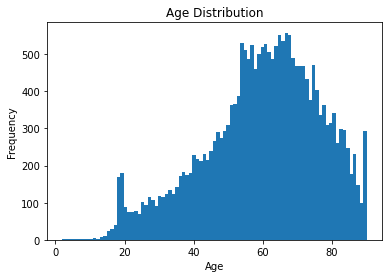

time: 428 ms (started: 2023-03-02 15:42:11 +00:00)


In [ ]:
#@title Age distribution

#Set all ages above 90 to 90
age = Y["age"].values
age[age > 90] = 90
bins = np.unique(age).size

# plot the age distribution
fig, ax = plt.subplots()
ax.hist(age, bins=bins)
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.set_title('Age Distribution')
plt.show()

Let us take a quick look at the data distribution for our most important feature, Age. The age distribution is quite varied, with samples from almost all age categories, but it skews quite heavily towards older ages nonetheless. This is natural, as we would expect the population with heart diseases to be generally older and given the nature of the dataset, it is to be expected.

It is worth noting that for privacy reasons, the dataset codes everyone older than 89 years old as 300 years old. The peak at 90 years old should therefore be interpreted as 90 years old or older in this graph.

Regarding the peak around 18~ years old, I do not currently have an explanation. Perhaps it might be due to volunteer students that were added to the dataset. While I did not have a chance to look into this issue further, it remains an abnormality in the data that should be investigated sooner rather than later.

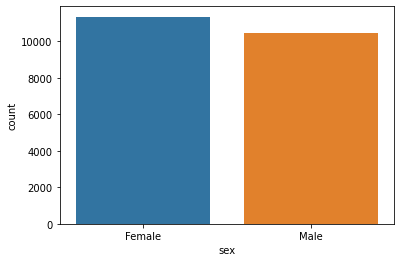

time: 187 ms (started: 2023-03-02 15:42:11 +00:00)


In [ ]:
#@title Sex distribution

sns.countplot(x='sex', data=Y)
plt.xticks(np.arange(2), ('Female', 'Male'))
plt.show()

Sex distribution is also a relevant topic, as diseases sometimes affect men and women differently, and having one of the categories underrepresented would likely cause the model to perform worse on that category. Luckily it seems that in this case the dataset is relatively balanced, we then need not worry about this problem.

One question that is not addressed by the dataset however, is the ethniticity of the patients which can also be a point of bias for the model, furthermore, cross-categories such as black males or white females might actually result underrepresented in the dataset, a fact that might be hidden while looking at their own individual categories, which could once again result in poor results for the model on these specific cross-categories as per my previous paragraph. 

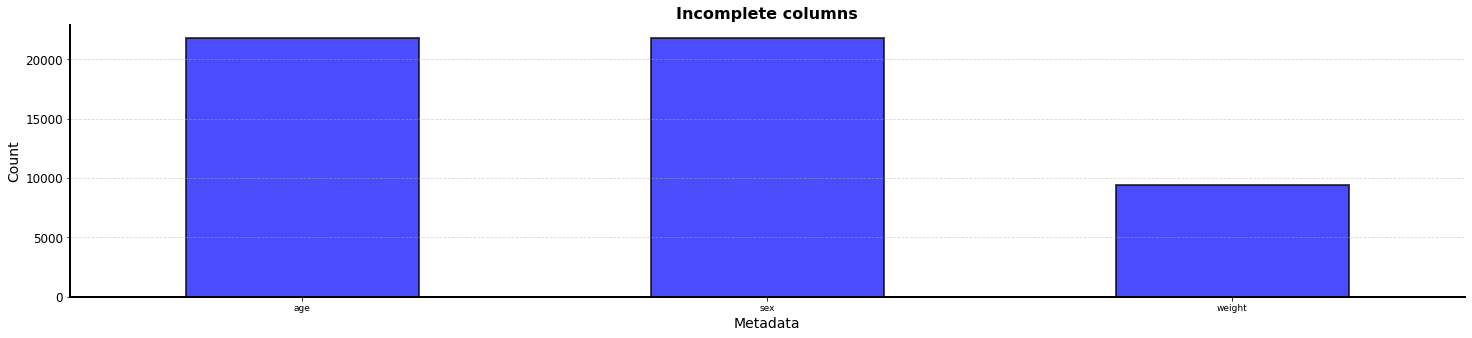

time: 603 ms (started: 2023-03-02 19:53:30 +00:00)


In [ ]:
#@title Incomplete columns

df = Y

# count the non-null values in each column
counts = df[["age", "sex", "weight"]].count().sort_values(ascending=False)

# set the figure size
plt.figure(figsize=(25, 5))

# create a bar graph of the counts
ax = counts.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black', linewidth=2)

# set the title and axis labels
plt.title('Incomplete columns', fontsize=16, fontweight='bold')
plt.xlabel('Metadata', fontsize=14)
plt.ylabel('Count', fontsize=14)

# set the font size for the tick labels
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=12)

# set the color and width of the axis spines
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show the plot
plt.show()

As I mentioned earlier, in order to train my logistic regression model, I had to drop all the rows that did not contain weight data in the dataset. Looking at the graph above, we can notice that the logistic regression model was ultimately fitted on approximately half the dataset.

Therefore, while weight might be an important feature that can help predict heart diseases, it would ultimately be quite difficult to use it in our final model, as it would need to function without some of its inputs half the time.

Another possible approach would be reconstructing the weight data from the rest of the dataset, also known as data imputation. The most straightforward approach would be to compute the median weight for each sex separately and fill in missing weight values with it. 

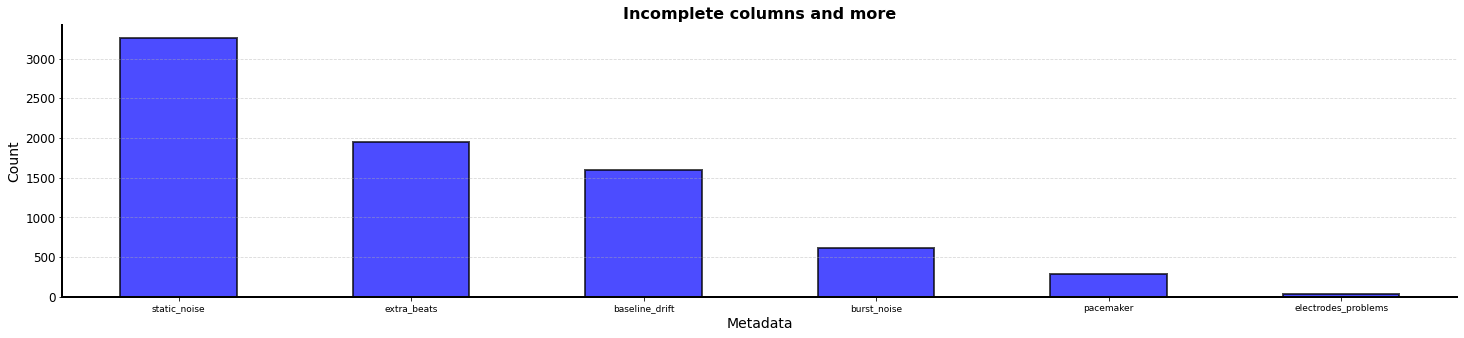

time: 394 ms (started: 2023-03-02 15:42:12 +00:00)


In [ ]:
#@title Noisy and special samples
df = Y

# count the non-null values in each column
counts = df[["static_noise", "burst_noise", "baseline_drift", "electrodes_problems", "extra_beats", "pacemaker"]].count().sort_values(ascending=False)

# set the figure size
plt.figure(figsize=(25, 5))

# create a bar graph of the counts
ax = counts.plot(kind='bar', color='blue', alpha=0.7, edgecolor='black', linewidth=2)

# set the title and axis labels
plt.title('Incomplete columns and more', fontsize=16, fontweight='bold')
plt.xlabel('Metadata', fontsize=14)
plt.ylabel('Count', fontsize=14)

# set the font size for the tick labels
plt.xticks(fontsize=9, rotation=0)
plt.yticks(fontsize=12)

# set the color and width of the axis spines
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# add grid
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show the plot
plt.show()

Here instead we can take a look at the number of noisy samples and other noteworthy abnormalities of the ECG signal. 

Overall, noisy samples make up a substantial percentage of the dataset underlining the importance of planning a viable approach to noise. It is worth noting that these categories are overlapping, with multiple types of noise being found in the same sample at times.


As previously mentioned, the pacemaker is another important feature in the dataset, as it causes a quite distinct and unique effect on the ECG graph. The number of samples, however, is tiny, and it might be insufficient for the model to understand the relation between pacemakers and the spikes they cause in the ECG graph. Nonetheless, it is an important aspect of the signal and due to its nature, strongly correlated with heart conditions. It might be therefore useful to augment the samples with simulated pacemaker spikes to compensate for the small amount of data available.

Electrodes problems are an extremely tiny part of this dataset, unable to be used to train a model on their detection as previously envisioned. The ideal approach for this type of task would likely then be an anomaly detection system trained on all the data except the electrode problems, which would then raise the alarm when the input is out of its known distribution, likely indicating electrode problems. To train a normal model instead, it would likely be best to simply filter out this data, as it will act only as a source of noise rather than a meaningful label.

Finally, extra_beats indicates the presence of a premature contraction in the cardiac rhythm. While the presence of an extra beat per se does not necessarily indicate an underlying heart condition that needs to be treated, it can be a great source of information that should be taken into account. To detect extra beats, an abnormality in the rhythm of the peaks or dips should be detected. As their detection can be a complex problem, compared to other features, I have decided to discard this data for the current challenge.


This concludes my analysis of the metadata present in the dataset and what it can tell us.

#ECG presentation

Here are the standards I followed in plotting the signals:


* The graph is labelled with a title reflecting the electrode being observed. 

* The signal is plotted black on a white background to maximize contrast, while the boxes are plotted pink in the style of meter paper.

* The x-axis is measured in seconds, while the y-axis is measured in mV, which is reflected in their labels.

* The vertical lines on the x-axis repeat in intervals of 0.2 and 0.04 seconds, while the y-axis is labelled in intervals of 0.1 mV.

For this example, I chose the testsample 37 (ecg_id 38 in the dataset) for its noisiness. I will showcase the signal and its pre-processing, the benefits of denoising and its limitations.

Specifically, the labels that interest us are the fact that it's NORM, static noise on all or most channels, and burst noise on V5. The report note specifically mentions the difficulty in determining the QRS axis, making this a difficult sample for doctors and machines alike.


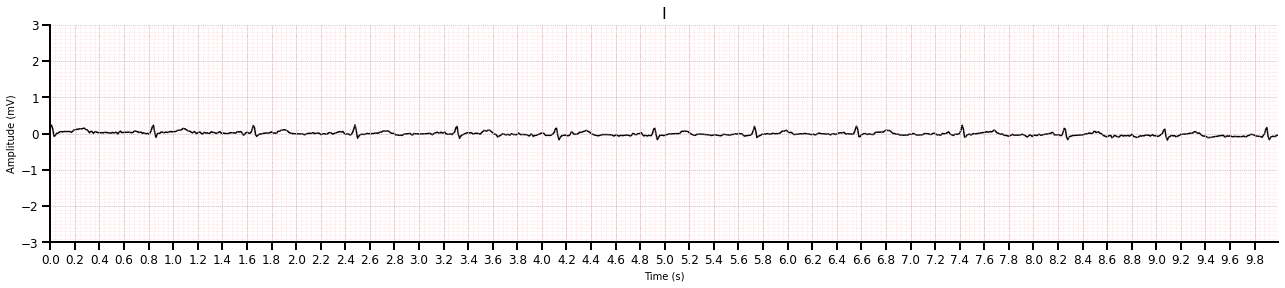

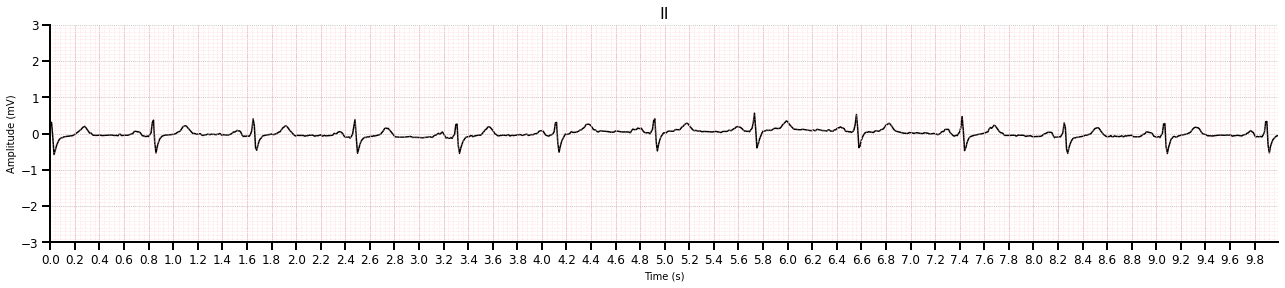

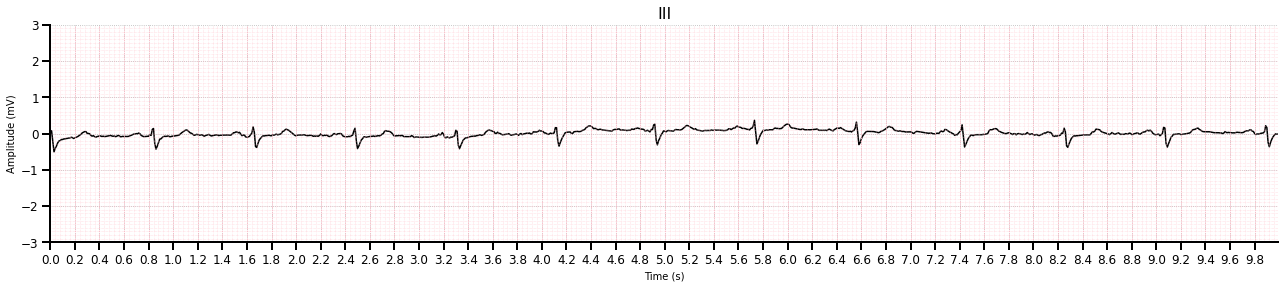

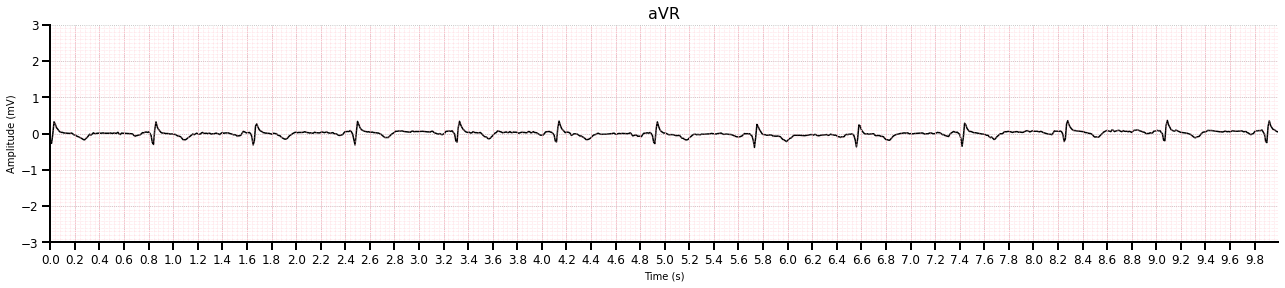

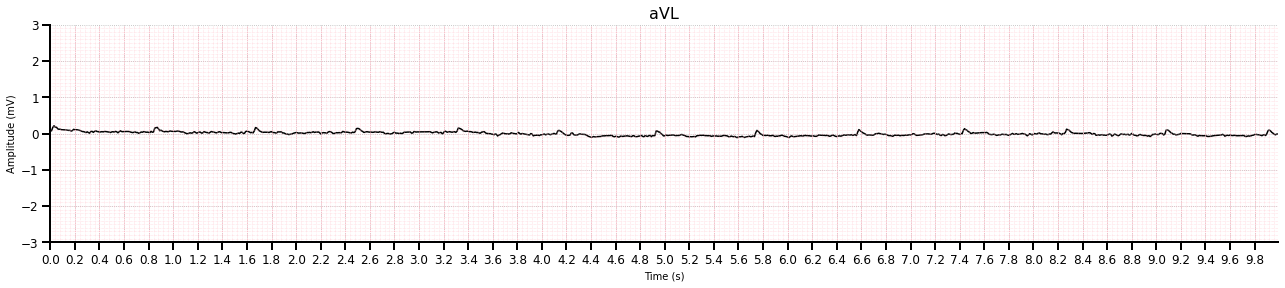

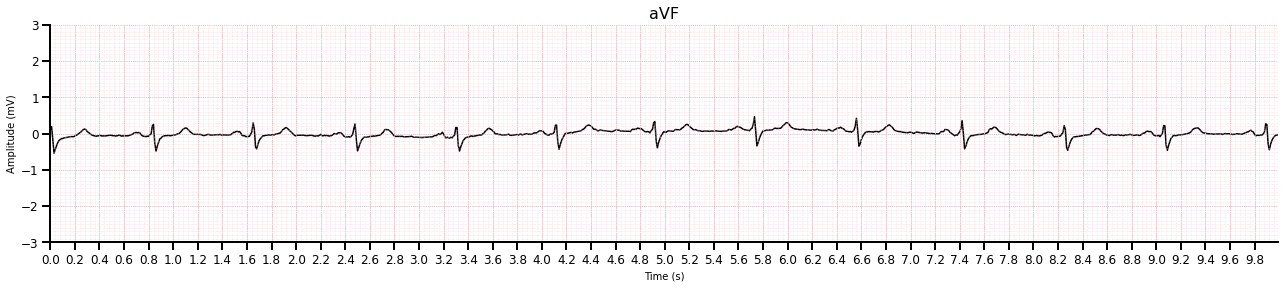

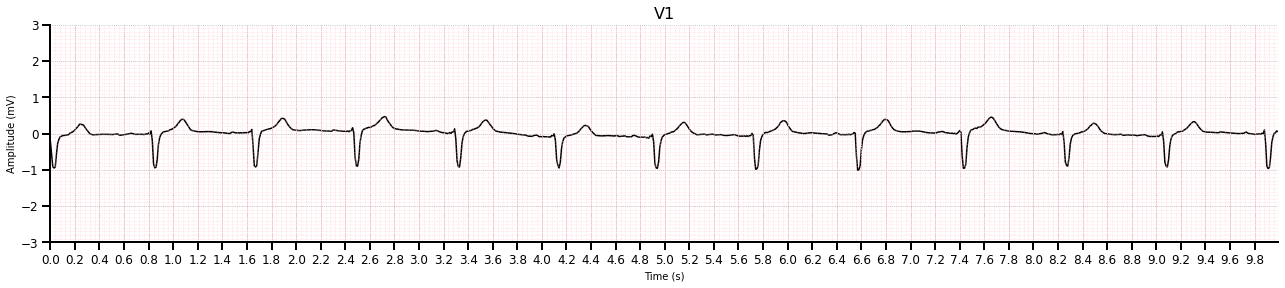

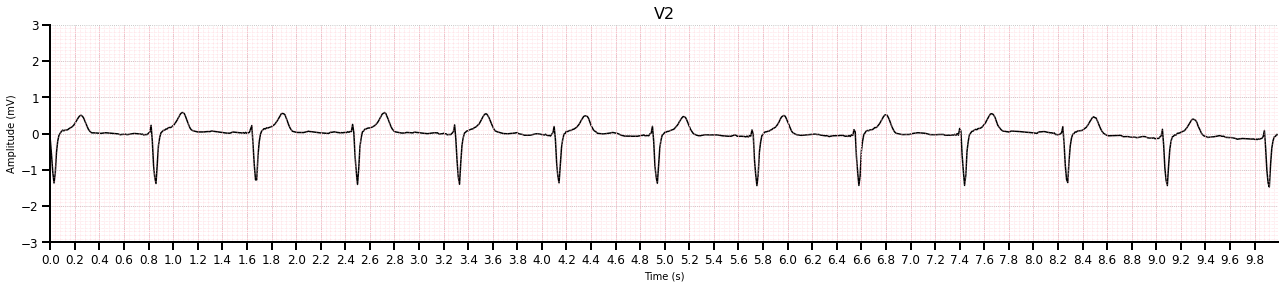

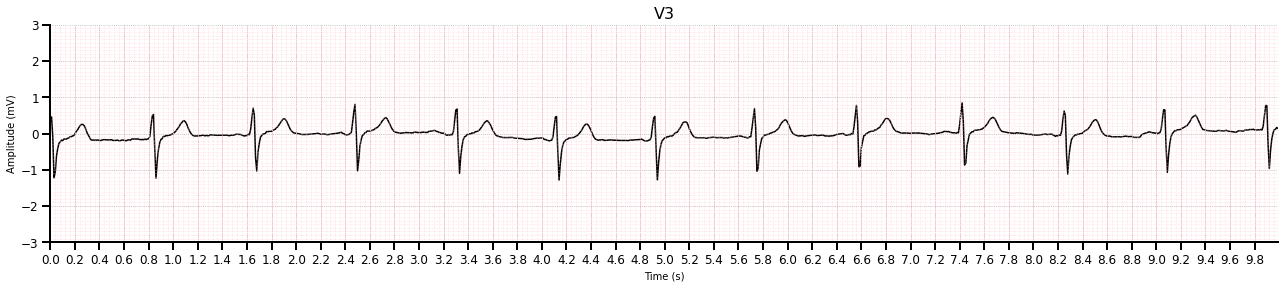

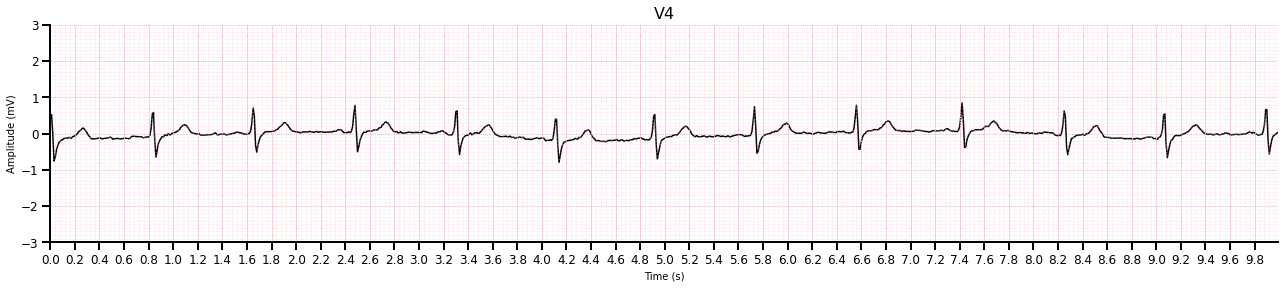

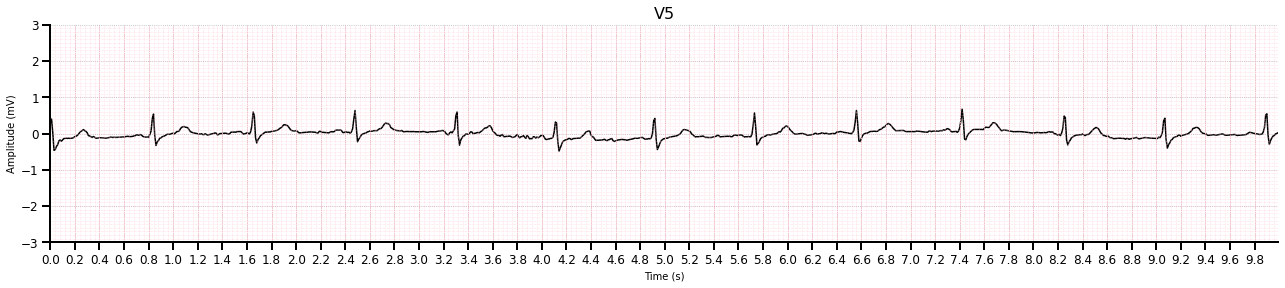

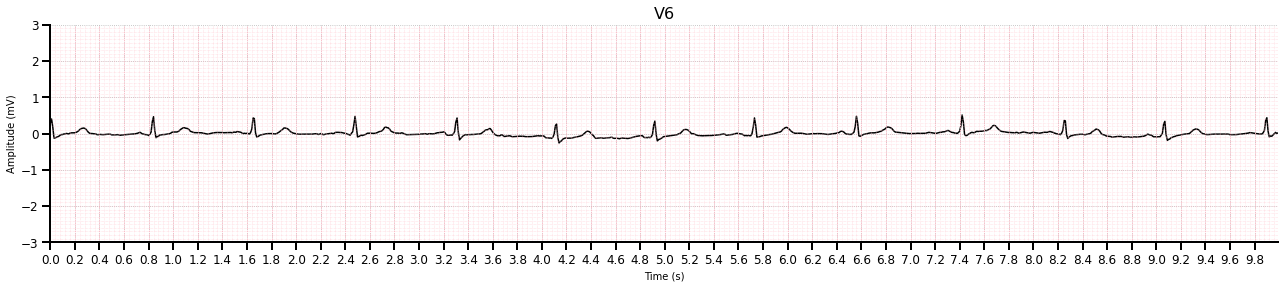

time: 17.4 s (started: 2023-03-02 15:42:12 +00:00)


In [ ]:
plot_signals(X[testsample])

As visible in the graph, the signal contains static noise in many of its leads, specifically, I notice it in I, II, III, aVR, and aVL. it also appears to me that V4 and V5 suffer from baseline drift. Finally, I and aVL are particularly weak signals to detect. 

For the next step, I will plot the signal after normalizing it between 0 and 1, the same type of pre-processing that I would apply to all signals in the dataset before training a model on them.

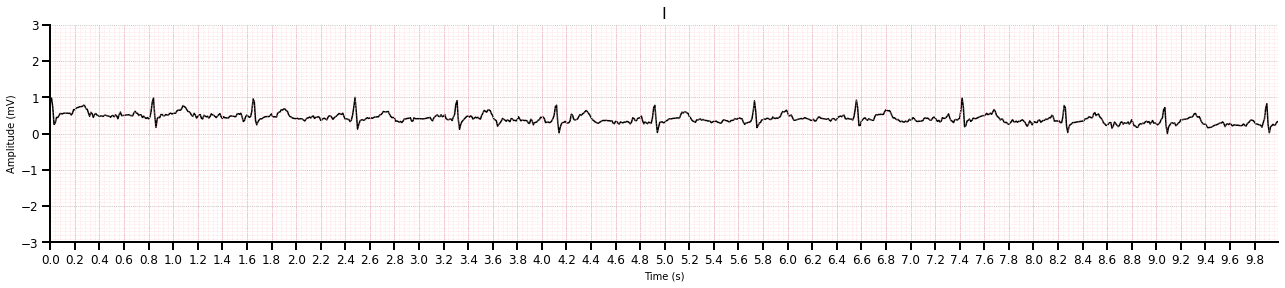

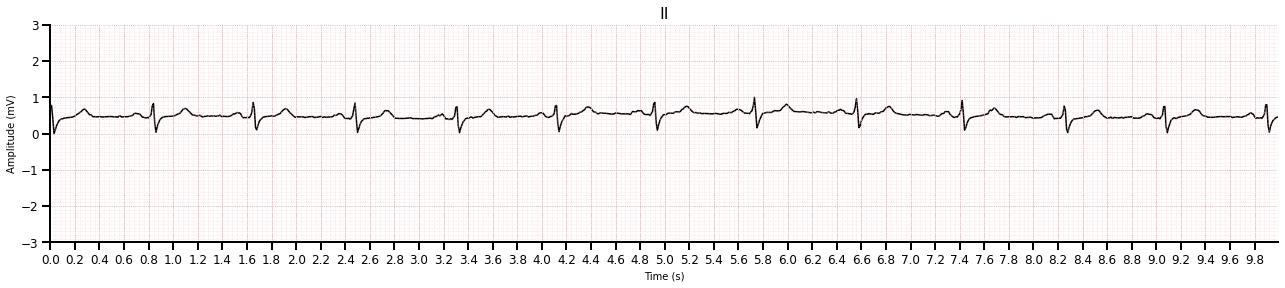

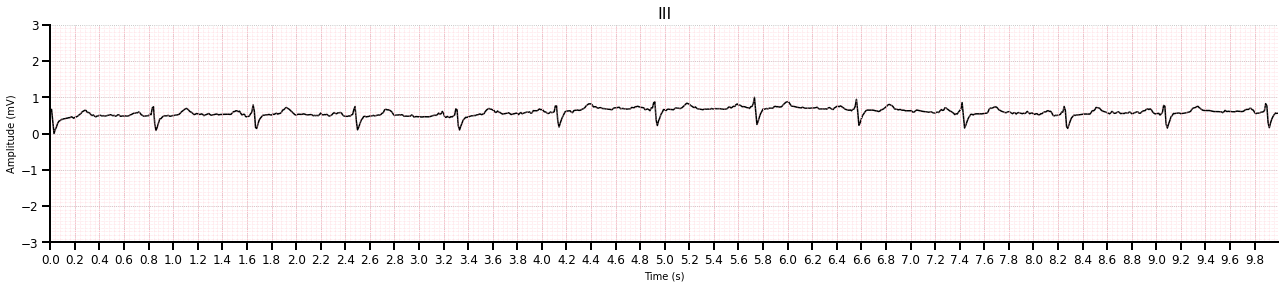

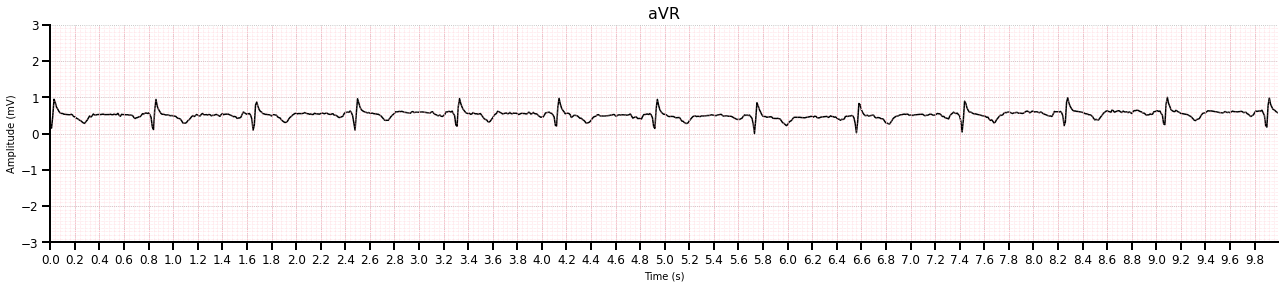

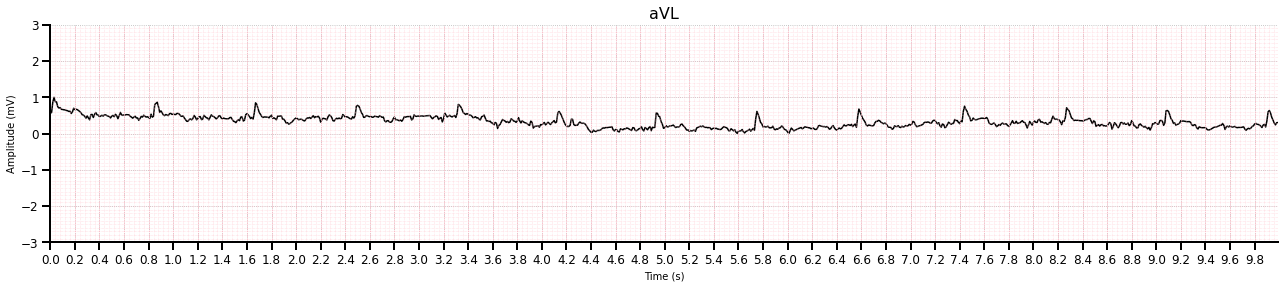

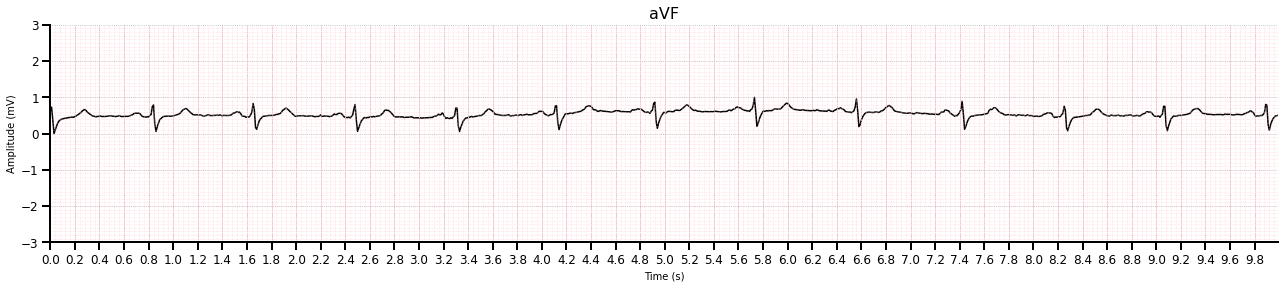

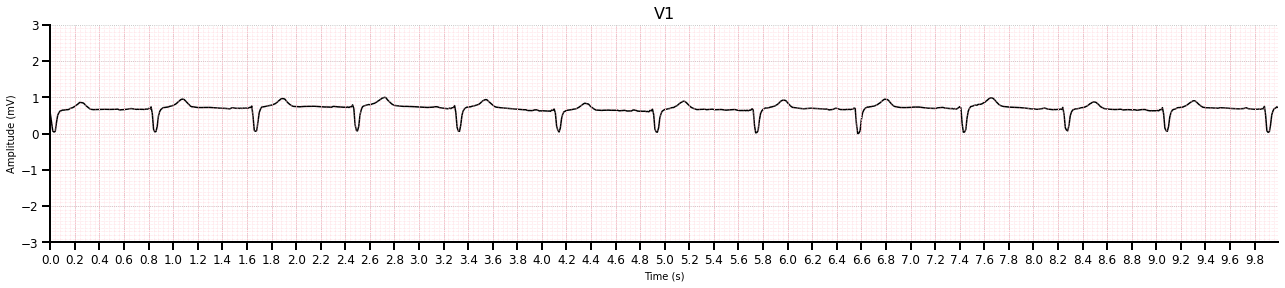

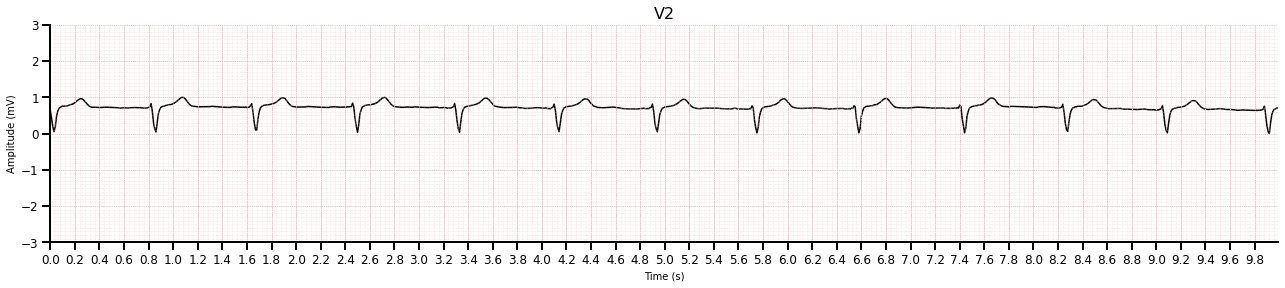

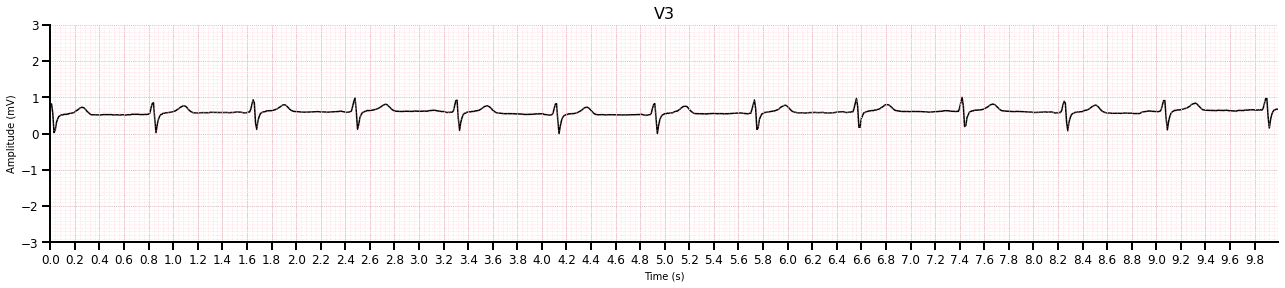

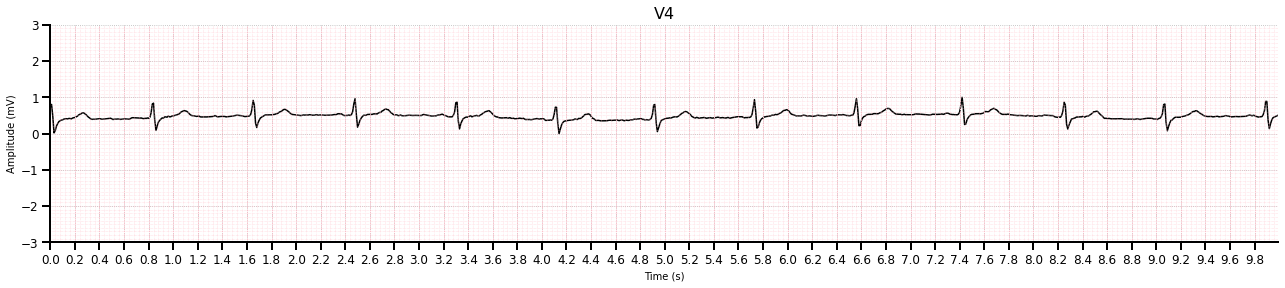

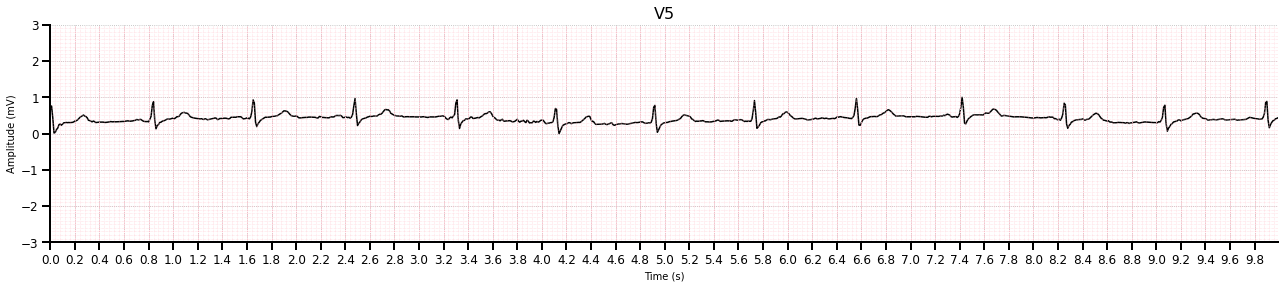

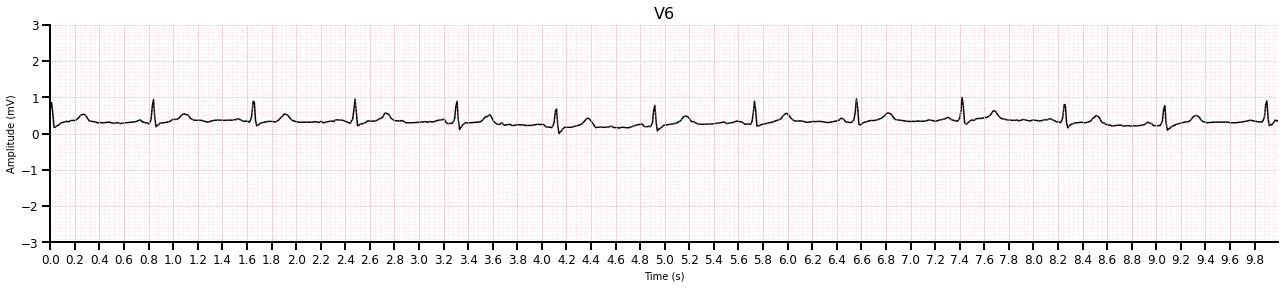

time: 18.3 s (started: 2023-03-02 15:42:30 +00:00)


In [ ]:
plot_signals(normalize_signals(X[testsample], 0, 1)) 

After normalization valuable information on the voltage of the signal is lost, however, a deep learning model would likely benefit from standardization of the values in the signal. Other approaches to be considered are normalizing the signal per batch during training, or reintroducing the voltage of R-peaks and other important amplitude features of the ECG as separate inputs to the model.

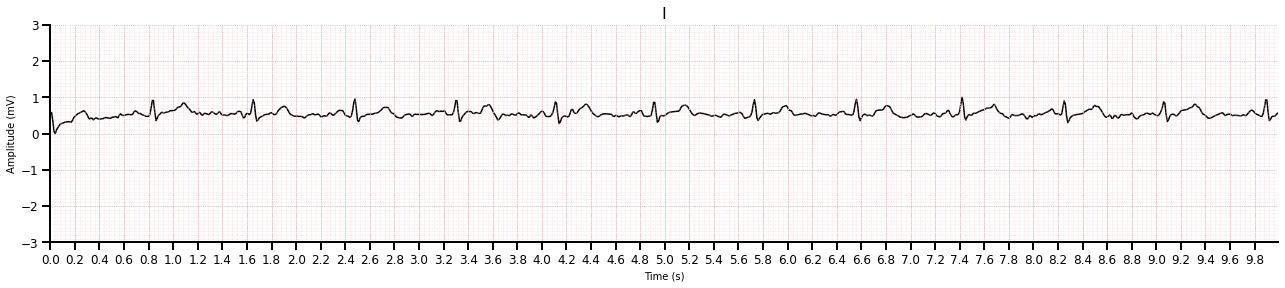

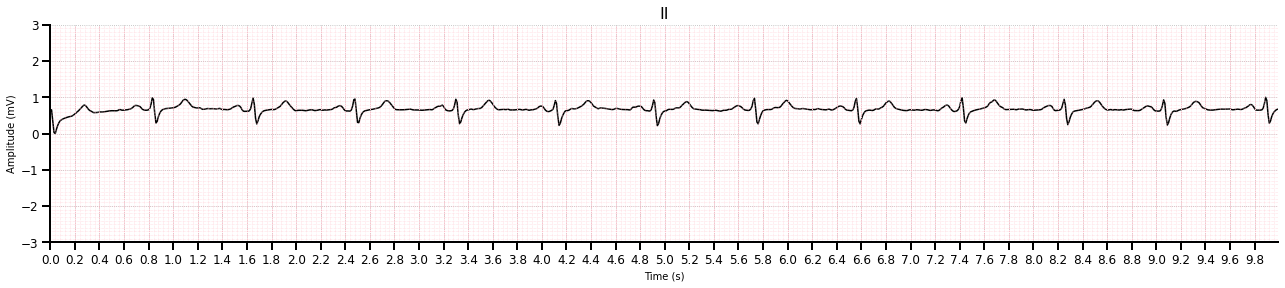

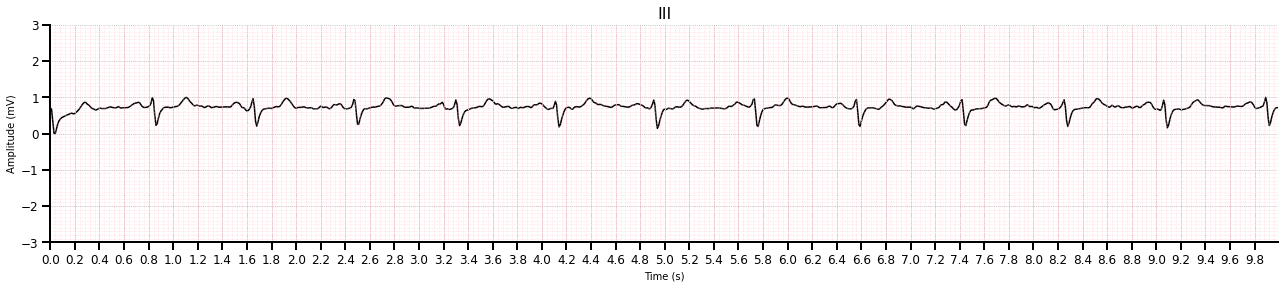

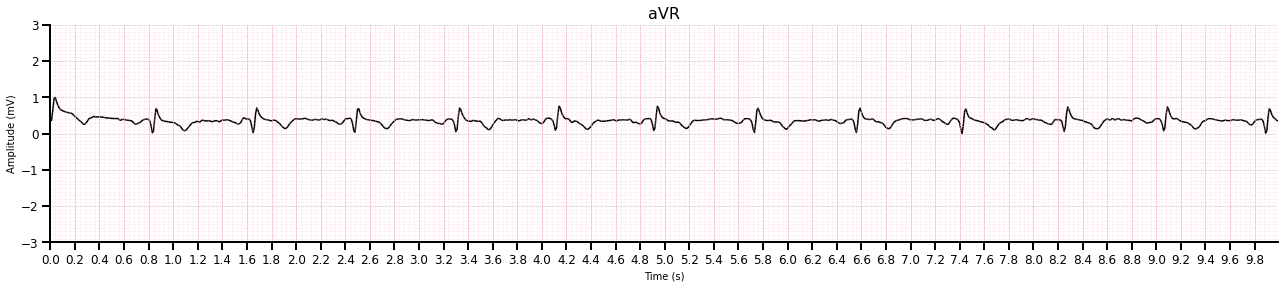

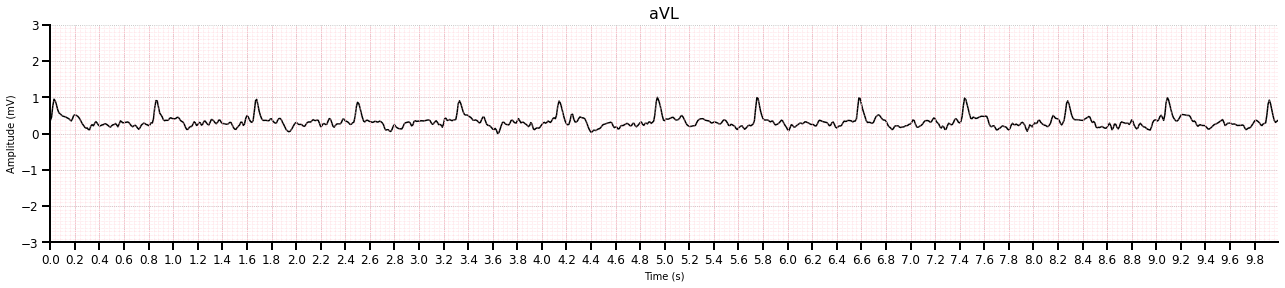

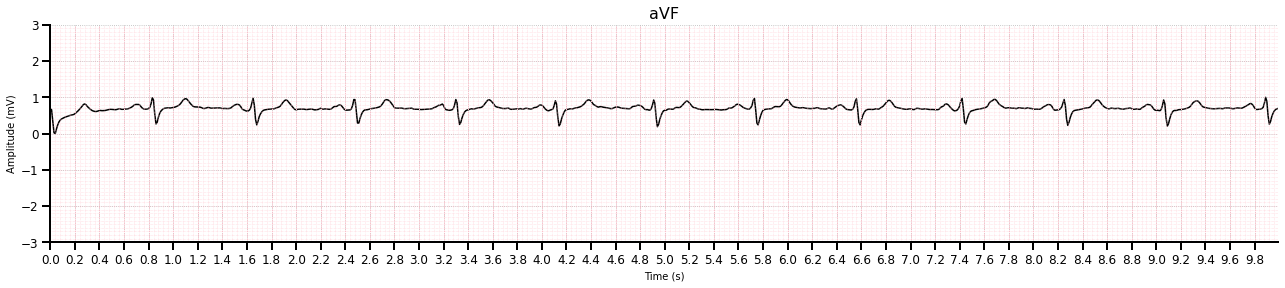

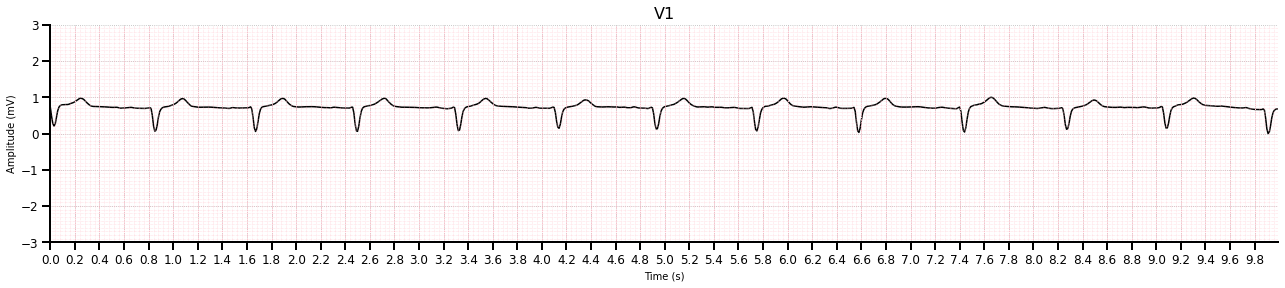

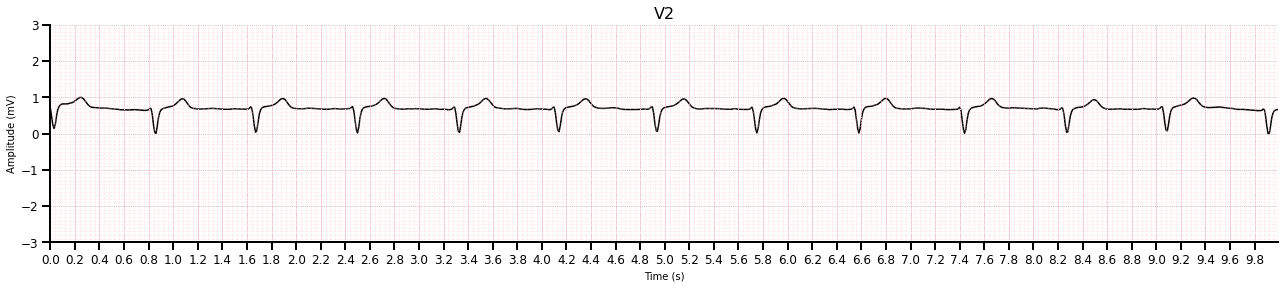

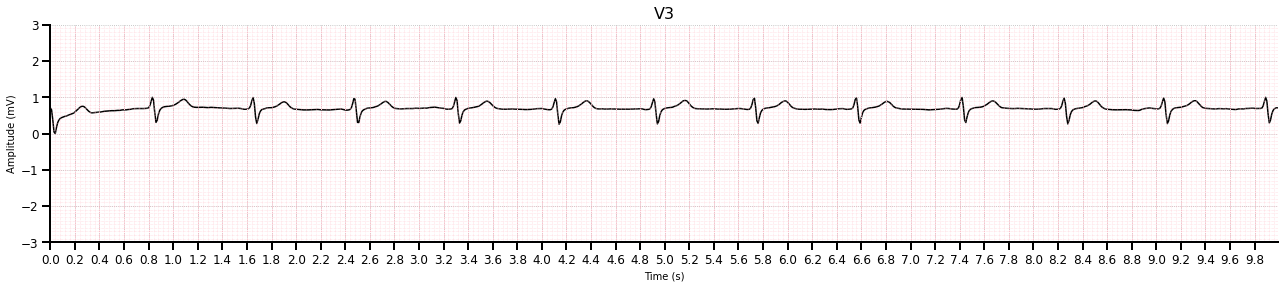

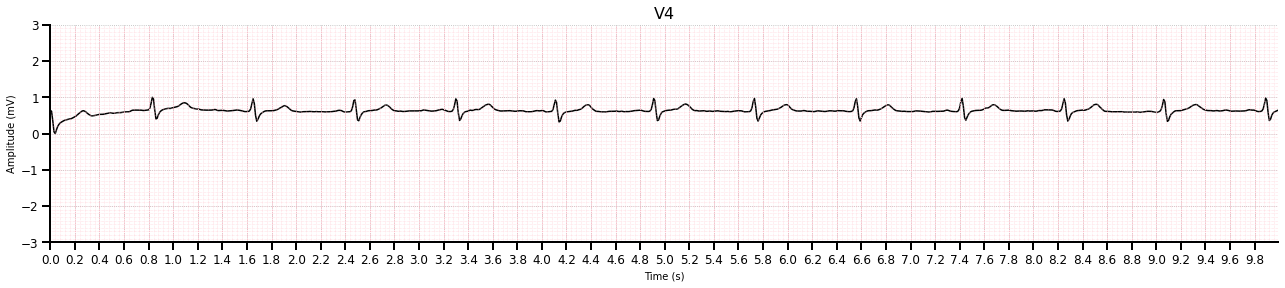

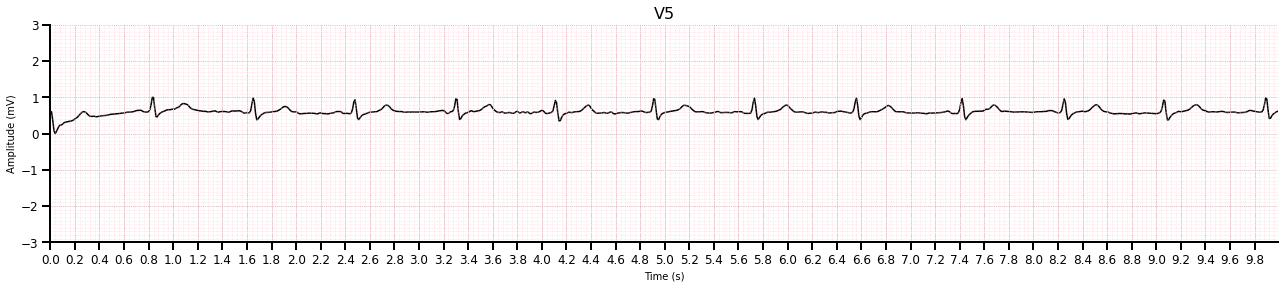

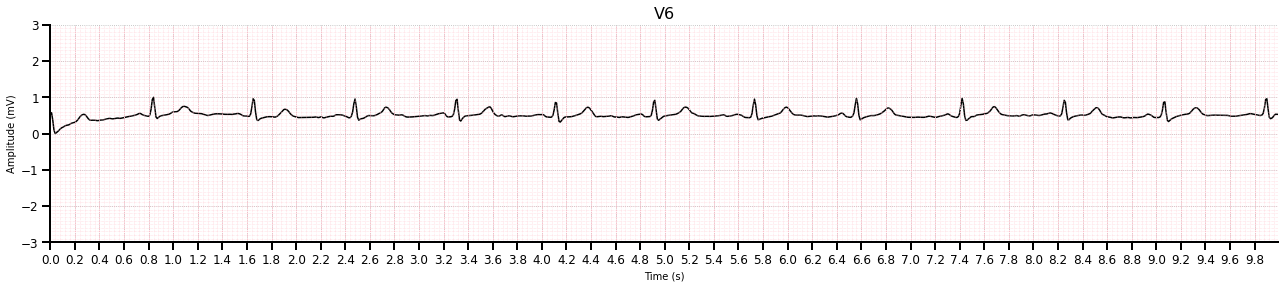

time: 22 s (started: 2023-03-02 15:42:48 +00:00)


In [ ]:
plot_signals(normalize_signals(denoise_ecg(X[testsample]),0 , 1))

Finally, we filter the signals.

For I the approach seems to have stabilized the baseline and made the QRS complex stand out more.

For II we can see a reduction in static noise, for example on the T-wave around the 7.7 seconds mark, but it also caused a change in baseline which is hard to identify as a positive or negative change.

For III we see a similar change in the baseline as II, plus a reduction in static noise and a better delineation of the QRS complex similarly to I.

For aVR, the baseline decreased and the peaks are less pronounced. It is hard to judge without being a medical expert, but this signal definitely looks quite different from the original. It appears to me that the filtering was partially destructive in this case.

For aVL, the removal of static noise seems to have instead allowed the ECG to be better defined, however, the limits of this filter can be seen. Lots of noise is still present, and the signal remains highly disturbed with sudden depressions and peaks.

In V4 and V5 the baseline appears to converge after around 1 second, which to me looks like an improvement over the previous signal. Nonetheless, the weird baseline drift that is present in the first second or so is not unique just to this sample and remains an undesirable pattern. Regarding V5, the burst noise seems to be mitigated as visible after the T-wave at the 3.8s mark.

In [ ]:
#@title Heart-rate, beats, and R-peaks
ecgdata = analyze_signals(X[testsample])

for key in ecgdata:
  print(key, ecgdata[key])

Signal  0
Heart rate: 72.90586731104783 BPM
Number of beats detected:  12
R peaks detected at:  [ 83 165 248 330 411 491 573 656 740 825 906 989] ms

Signal  1
Heart rate: 72.89694249995469 BPM
Number of beats detected:  12
R peaks detected at:  [ 83 165 247 330 411 491 573 656 742 825 906 989] ms

Signal  2
Heart rate: 72.8996094182269 BPM
Number of beats detected:  12
R peaks detected at:  [ 83 165 247 330 411 491 572 655 741 825 906 989] ms

Signal  3
Heart rate: 72.95466317241875 BPM
Number of beats detected:  12
R peaks detected at:  [ 87 168 251 334 415 495 576 659 745 828 909 993] ms

Signal  4
Heart rate: 72.99958654624614 BPM
Number of beats detected:  12
R peaks detected at:  [ 87 168 250 333 414 494 576 659 743 828 909 992] ms

Signal  5
Heart rate: 72.8993327666302 BPM
Number of beats detected:  12
R peaks detected at:  [ 83 165 247 330 411 491 572 656 741 825 906 989] ms

Signal  6
Heart rate: 72.91747536960337 BPM
Number of beats detected:  12
R peaks detected at:  [ 81 1

In this sub-section I analysed the 12 leads of an ECG signal separately and computed their heart rate, the number of beats detected and the location of the R-peaks. To detect the R_peaks I used neurokit's function in which which the QRS complexes in an ECG are identified by measuring the steepness of the absolute gradient of the signal. Within the QRS complexes, the R-peaks are identified as the local maxima in the signal.

Looking at the data, the results are quite consistent between the different leads, with minimal variations in the detection of R-peaks which is absolutely within the norm considering the lead placements. The number of beats and the heart rate detected is also perfectly consistent, which is expected as they are both derived from the R-peaks detected and the RR interval.

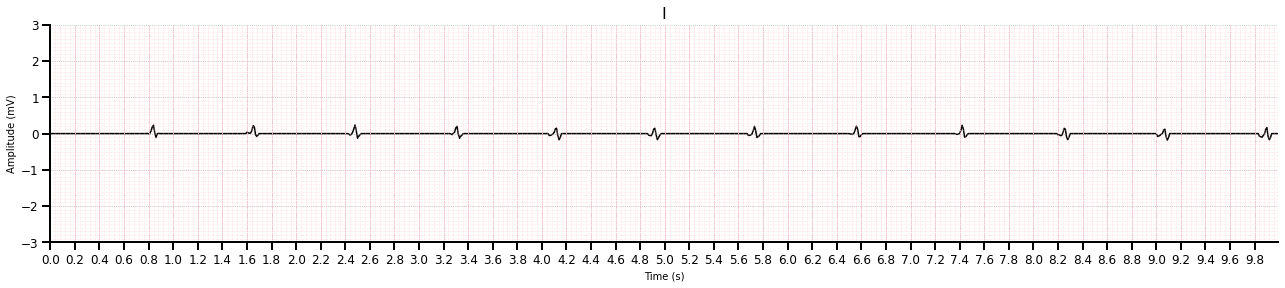

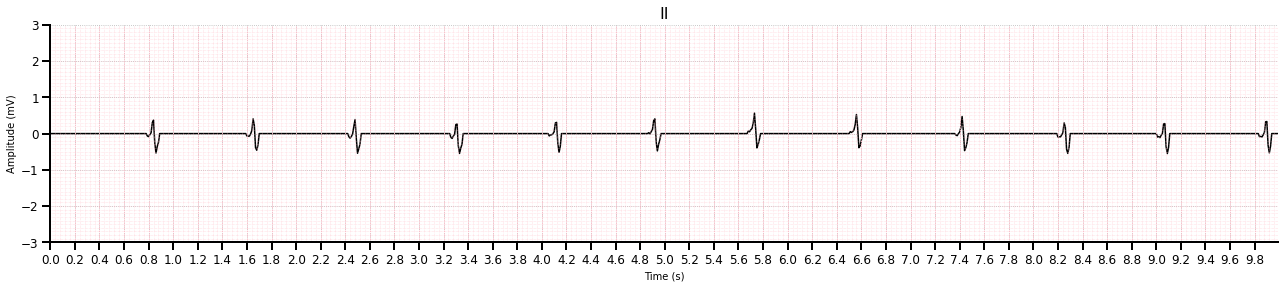

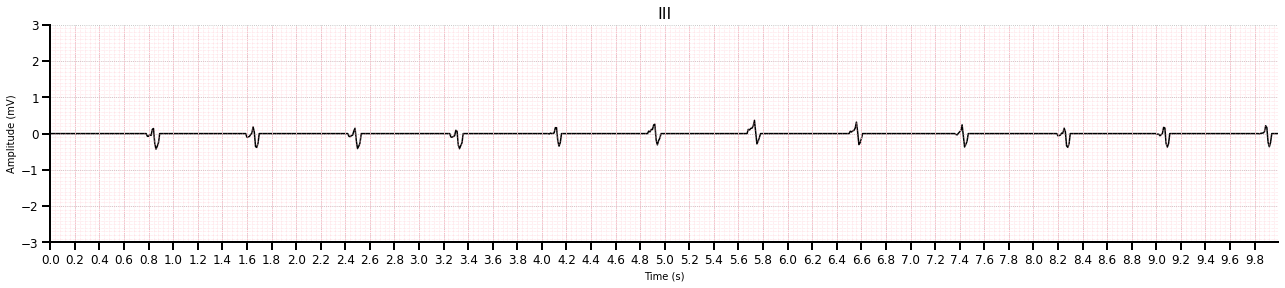

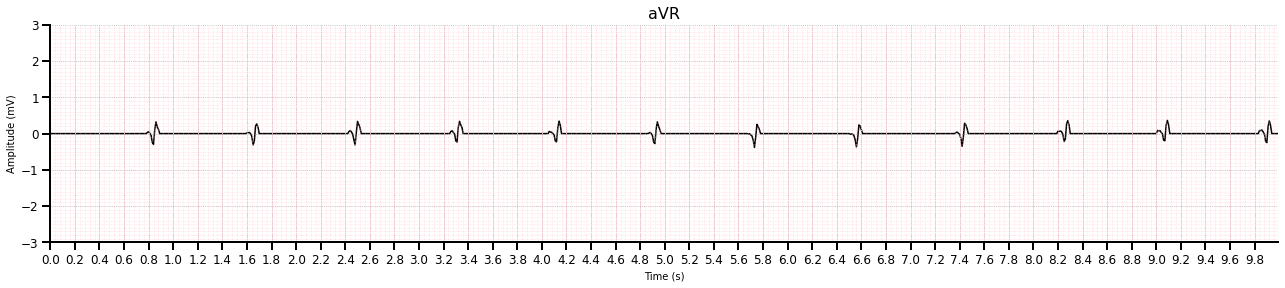

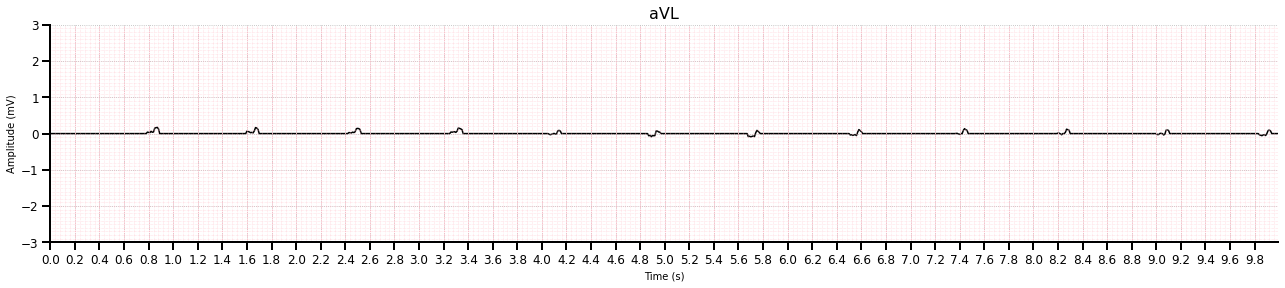

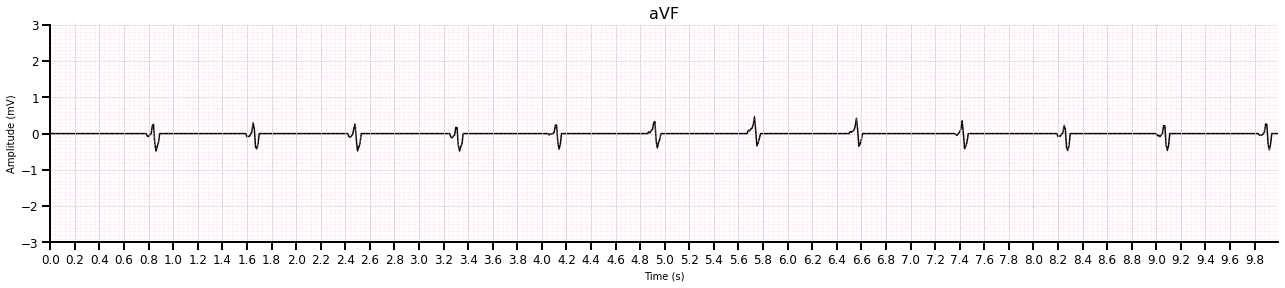

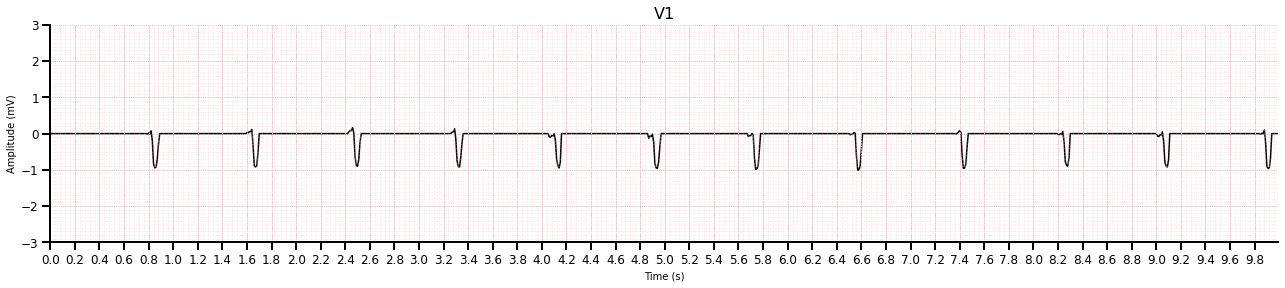

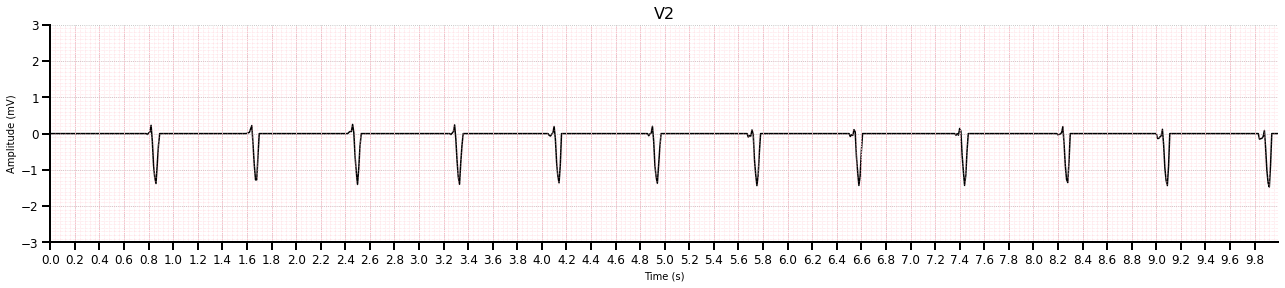

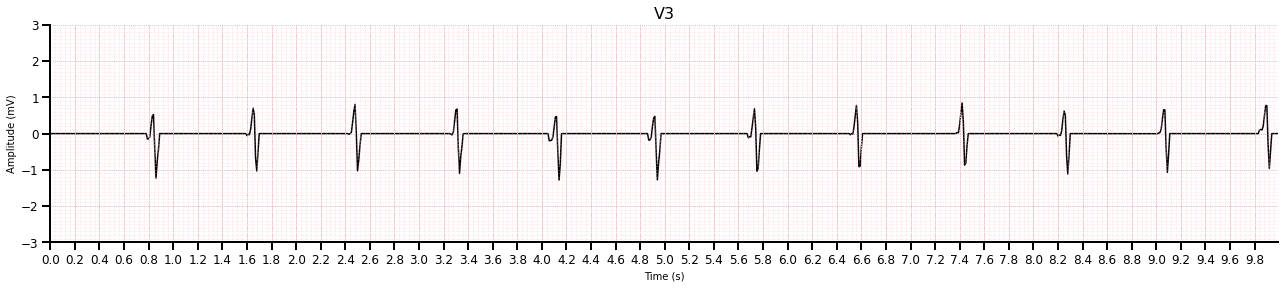

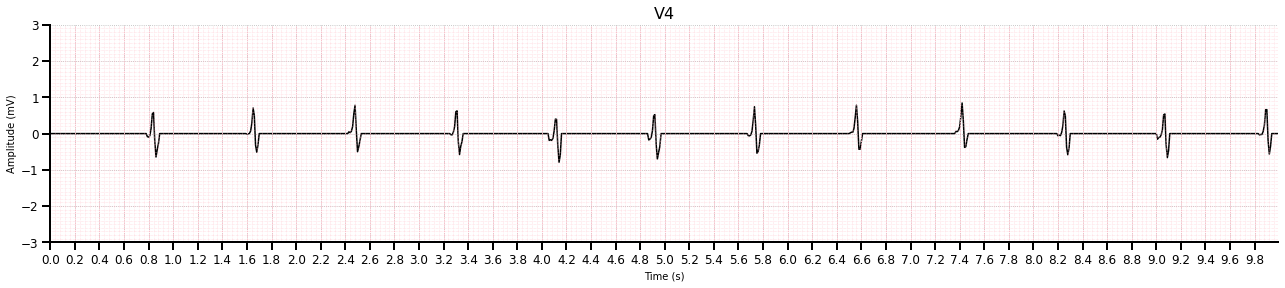

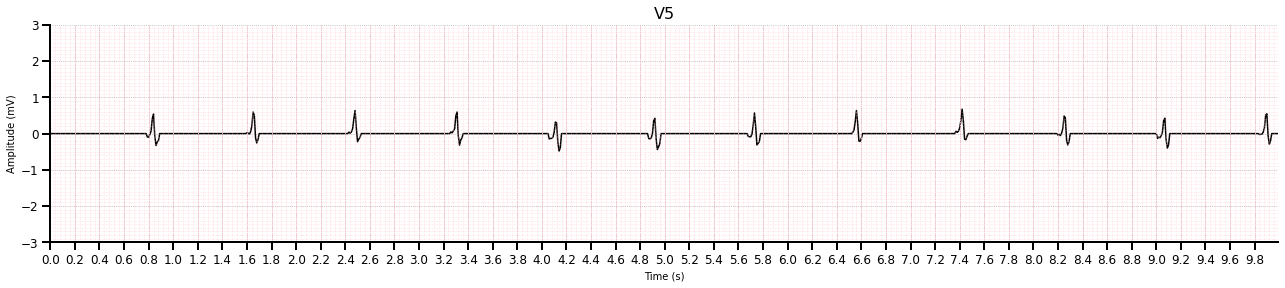

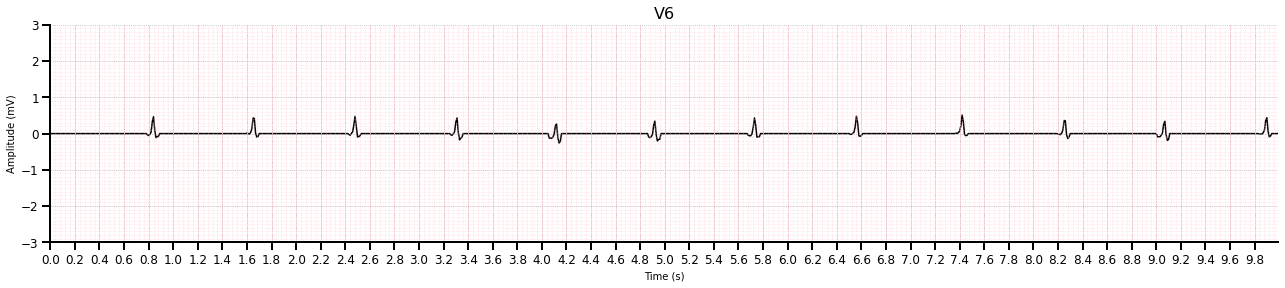

time: 19.2 s (started: 2023-03-02 15:43:13 +00:00)


In [ ]:
#@title Plotting QRS

plot_QRS(ecg_signals = X[testsample], r_peaks = ecgdata["r_peaks"], sampling_rate = sampling_rate)

In this subsection, I took the previously detected R-peaks and plotted a window of 0.12~ seconds around them to capture the QRS complex. This approach relies on the assumption that the QRS signal has an average and normal duration, and it might not work as well in cases where its duration is either decreased or increased. 

In the former case, we would expect to see a part or all of the P-wave and in more extreme cases the T-wave too. In the latter, parts of the QRS complex would instead be lost in the plot.

Despite this drawback, this approach shows that at least for the chosen sample, the R-peak detection functions correctly, as the window around it captures the QRS complex. This information could be used to highlight the QRS complex on the original graph as well.

In [ ]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)]
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold]

time: 2.63 s (started: 2023-03-02 15:43:32 +00:00)


In [ ]:
X_features_train, y_features_train = extract_features(X_train, y_train)
X_features_test, y_features_test = extract_features(X_test, y_test)

We split the data in training and testing and extract its features. For simplicity the features extracted come solely from the channel I.

The list of features is as follows:

["ECG_R_Peaks", "ECG_P_Peaks", "ECG_Q_Peaks", "ECG_S_Peaks", "ECG_T_Peaks", "ECG_P_Onsets", 
              "ECG_P_Offsets", "ECG_R_Onsets", "ECG_R_Offsets", "ECG_T_Onsets", "ECG_T_Offsets", "ECG_Phase_Atrial", 
              "ECG_Phase_Completion_Atrial", "ECG_Phase_Ventricular", "ECG_Phase_Completion_Ventricular", "ECG_Rate",
              "PR_Segment", "ST_Segment", "ST_Interval", "QRS_Duration", "Age", "Sex"]

Age and Sex were chosen due earlier logistic regression model. The expectation is that Age will bring a large impact as it did before, while Sex might reveal more interesting as a feature with Weight gone and more variables at play.

The peaks, onsets, and offests, are actually the mean amplitude value of those features detected within the signal. These features were chosen to introduce information regarding the voltage of the ECG.

ECG_rate, or heart rate, is an important feature to determine the overall health of the heart.

PR_Segment, ST_Segment, ST_Interval, and QRS_Duration are all important metrics according to ECG literautre and were therefore extracted and included. Due to the limits of my analysis they are only an approximation of the real metric, but I think that they could play a relevant part in the model. Furthermore they introduce the time dimension of the ECG into the features of the model.

I have also chosen to introduce the mean amplitude values of the ECG_Phase_Atrial, ECG_Phase_Completion_Atrial, ECG_Phase_Ventricular, ECG_Phase_Completion_Ventricular. Unlike the other metrics chosen, I do not have a particular support in literature for this metric, but I think introducing them has its merits.


The reason is two-fold, first of all they describe the mean value of the ECG throughout a longer period of time compared to just the peaks, which is something that is not currently present at all in the other featuers. Secondly, one of the strengths of the random forest architecture is the ability to quickly and easily remove the least relevant features at minimal loss of performance during training. This enables me to experiment a bit more with the features chosen without compromising my model. 

Ultimately, my approach is experimental and its final purpose is data exploration. Training a state-of-the-art model would require a different architecture and approach, but that is not the goal of my research today. 

In [ ]:
#@title Training a random forest model on the extracted features

for superclass in range(5):
  # Creating the hyperparameter grid
  param_grid = {
      'n_estimators': [200, 500],
      'max_depth': [ 10, 20],
      'criterion': ['gini', 'entropy'],
      'min_samples_split': [4, 8]
  }

  # Instantiating Random Forest classifier
  rf_model = RandomForestClassifier(random_state=0)

  # Instantiating the GridSearchCV object
  grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

  # Fitting the model
  grid_search.fit(X_features_train, y_features_train.iloc[:,superclass])

  # Print the best hyperparameters
  print("Best Hyperparameters: {}".format(grid_search.best_params_))

  # Predicting on the test set
  y_pred_rf_opt = grid_search.predict(X_features_test)

  # Evaluating the model
  accuracy_rf_opt = accuracy_score(y_features_test.iloc[:,superclass], y_pred_rf_opt)
  precision_rf_opt = precision_score(y_features_test.iloc[:,superclass], y_pred_rf_opt)
  recall_rf_opt = recall_score(y_features_test.iloc[:,superclass], y_pred_rf_opt)

  print("\nAccuracy:", accuracy_rf_opt)
  print("Precision:", precision_rf_opt)
  print("Recall:", recall_rf_opt)

  # Get numerical feature importances
  importances = list(grid_search.best_estimator_.feature_importances_)
  features = ["ECG_R_Peaks", "ECG_P_Peaks", "ECG_Q_Peaks", "ECG_S_Peaks", "ECG_T_Peaks", "ECG_P_Onsets", 
              "ECG_P_Offsets", "ECG_R_Onsets", "ECG_R_Offsets", "ECG_T_Onsets", "ECG_T_Offsets", "ECG_Phase_Atrial", 
              "ECG_Phase_Completion_Atrial", "ECG_Phase_Ventricular", "ECG_Phase_Completion_Ventricular", "ECG_Rate",
              "PR_Segment", "ST_Segment", "ST_Interval", "QRS_Duration", "Age", "Sex"]
  
  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 3)) for feature, importance in zip( features, importances)]

  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  # Print out the feature and importances 
  [print('\nVariable: {:20} Importance: {:.3f}'.format(*pair)) for pair in feature_importances];

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 4, 'n_estimators': 500}

Accuracy: 0.8034576888080073
Precision: 0.7488284910965324
Recall: 0.829698857736241

Variable: ECG_T_Peaks          Importance: 0.108

Variable: ECG_Phase_Ventricular Importance: 0.103

Variable: ECG_P_Onsets         Importance: 0.074

Variable: Age                  Importance: 0.073

Variable: ECG_Q_Peaks          Importance: 0.067

Variable: ECG_P_Offsets        Importance: 0.052

Variable: ECG_S_Peaks          Importance: 0.051

Variable: ECG_R_Peaks          Importance: 0.050

Variable: ECG_Phase_Atrial     Importance: 0.037

Variable: ECG_T_Onsets         Importance: 0.036

Variable: ECG_T_Offsets        Importance: 0.036

Variable: ECG_Phase_Completion_Ventricular Importance: 0.036

Variable: ECG_Phase_Completion_Atrial Importance: 0.035

Variable: ST_Segment           Importance: 0.033

Variable: ECG_P_Peaks  

# Training and results

Here is how I trained five random forest models on the extracted features. The dataset contains five different binary classification tasks, so rather than creating a deep and complex tree I decided to iterate over each label.

To optimize the model's hyperparameters, I used the GridSearchCV object to perform a search over a predefined hyperparameter grid. The parameters were rapidly iterated on from the results of previous runs with fewer parameters and samples. RandomSearch could have also worked in this case.

Next, I used the trained model to make predictions on the test set and evaluated the performance using accuracy, precision, and recall metrics. Another interesting metric that I could have reported is the F1 score, a staple in ML literature.

To gain insight into which features were most important, I calculated the feature importances for the best-performing model. With this, I reintroduced a degree of interpretability back into the model.

Here are the insights I gained from training this model:

* By summing their feature importances, the top 7 features are ECG_T_Peaks, ECG_Phase_Ventricular, ECG_R_Peaks, ECG_P_Onsets, Age, ECG_Q_Peaks. The bottom 7 are ECG_R_Onset, ECG_Rate, ECG_P_Peaks, QRS_Duration, ST_Interval, PR_Segment, Sex.

* Three peaks are found in the top 7 features, this is likely due to their importance as a feature per se but also due to the ease of extraction of the feature itself. The presence of PR_Segment, ST_Interval, and QRS_duration in the bottom 7 is, in my opinion, due to poor approximation of the real feature. More work is required in that regard.

* Age consistently scores high in feature importance, while Sex remains a not-so-important feature matching my previous results with logistic regression.

* The experimental feature ECG_Phase_Ventricular proved to be surprisingly useful, scoring second overall, meaning that my data exploration paid off.

Ultimately, this is just a preliminary result. Better feature extraction and data imputation alone could greatly change the landscape of these features, but it is an interesting first look at this dataset and problem.


# Conclusion



To conclude my notebook, here is what I would have liked to do but did not have the chance or time to do:

Investigate the anomaly in the age distribution near the age of 18.

Explore extra heartbeat identification.

Extracting better features from the ECG signal.

Extracting features from each channel of the ECG signal rather than only I.

Analyze samples in the frequency domain.

Train a variety of models:

A **deep convolutional neural network** for superclass multilabel detection. It should be able to use all the channels and the entirety of the ECG signal sample without issues.

An **autoencoder** trained on the NORM class for self-supervised anomaly detection. Large inconsistencies in the reconstructed data would classify it as a non-healthy patient, furthermore, the difference between the original signal and the reconstructed one could be used to underline the location of the anomaly to the user, making the model interpretable. The approach could be pushed further by training more models on each of the superclasses and having the detected class be the one the model with the lowest reconstruction rate was trained on.

A **variational autoencoder** to compress the signal and a **transformer** to learn from the compressed representation. One of my first thoughts when considering an ECG signal is that much of the sample is not very useful to predict the heart condition and that most of the information is concentrated near the QRS complex and other limited locations. 

My approach is inspired by the use of VAE in Stable Diffusion, the current state-of-the-art in image generation. If images of 512x512 pixels can be compressed into a simple 64x64 pixel representation with a vae, a 1000\5000 sample signal can likely be extremely compressed as well. After compression, training a powerful but expensive architecture like a transformer would be quite feasible. 

To summarize, training a VAE to encode (and decode) images in an extremely compressed latent space, then teaching a transformer model (or similar SOTA) to predict the labels from this compressed representation.

This concludes my exploration and analysis of the dataset.